# Implementation of YIN Algorithm

https://github.com/NValsted/VForScienceProjects/blob/master/YIN_pitch_detection/pitch_detection.py

# Imports

In [3]:
from scipy.io import wavfile
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from dataclasses import dataclass

# Function Definitions

In [23]:
def f(x):
    f_0 = 1
    envelope = lambda x: np.exp(-x)
    return np.sin(2*np.pi*f_0*x) * envelope(x)

# def ACF( f, W, t, lag):
#     return np.sum( f[t : t + W] * f[lag + t : lag + t + W] )

def ACF(f, W, t, lag):
    corr = np.correlate(f[t : t + W], f[lag + t : lag + t + W], mode = 'valid')
    return corr[0]

def DF(f , W, t, lag):
    return ACF(f, W, t, 0) + ACF(f, W, t + lag, 0) - (2 * ACF(f, W, t, lag))

def CMNDF(f, W, t , lag):
    if lag == 0:
        return 1
    return DF(f, W, t, lag) / np.sum([DF(f, W, t, j+1) for j in range(lag)]) * lag

#############################################

def memo_CMNDF(f, W, t, lag_max):
    running_sum = 0
    vals = []
    for lag in range(0, lag_max):
        if lag == 0:
            vals.append(1)
            running_sum += 0
        else:
            running_sum += DF(f, W, t, lag)
            vals.append(DF(f, W, t, lag) / running_sum * lag)
    return vals

In [6]:
def detect_pitch( f, W, t, sample_rate, bounds, thresh = 0.1):
    CMNDF_vals = [CMNDF(f, W, t, i) for i in range(*bounds)]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]


    return sample_rate / sample

#####################################################
def augmented_detect_pitch_CMNDF(f, W, t, sample_rate, bounds, thresh=0.1):  # Also uses memoization
    CMNDF_vals = memo_CMNDF(f, W, t, bounds[-1])[bounds[0]:]
    sample = None
    for i, val in enumerate(CMNDF_vals):
        if val < thresh:
            sample = i + bounds[0]
            break
    if sample is None:
        sample = np.argmin(CMNDF_vals) + bounds[0]
    return sample_rate / (sample + 1)

In [4]:
# Numpy array of all note frequencies from C0 to B8
noteFrequencies = np.array([16.35,  17.32,  18.35,  19.45,  20.60,  21.83,  23.12,  24.50,  25.96,  27.50,  29.14,  30.87,
                            32.70,  34.65,  36.71,  38.89,  41.20,  43.65,  46.25,  49.00,  51.91,  55.00,  58.27,  61.74,
                            65.41,  69.30,  73.42,  77.78,  82.41, 87.31, 92.50, 98.00, 103.83, 110.00, 116.54, 123.47,
                            130.81, 138.59, 146.83, 155.56, 164.81, 174.61, 185.00, 196.00, 207.65, 220.00, 233.08, 246.94,
                            261.63, 277.18, 293.66, 311.13, 329.63, 349.23, 369.99, 392.00, 415.30, 440.00, 466.16, 493.88,
                            523.25, 554.37, 587.33, 622.25, 659.25, 698.46, 739.99, 783.99, 830.61, 880.00, 932.33, 987.77,
                            1046.50, 1108.73, 1174.66, 1244.51, 1318.51, 1396.91, 1479.98, 1567.98, 1661.22, 1760.00, 1864.66, 1975.53,
                            2093.00, 2217.46, 2349.32, 2489.02, 2637.02, 2793.83, 2959.96, 3135.96, 3322.44, 3520.00, 3729.31, 3951.07,
                            4186.01, 4434.92, 4698.63, 4978.03, 5274.04, 5587.65, 5919.91, 6271.93, 6644.88, 7040.00, 7458.62, 7902.13])

# Numpy array of intermediate frequencies between each note
halfFrequencies = np.array([np.mean([noteFrequencies[i], noteFrequencies[i+1]]) for i in range(len(noteFrequencies)-1)])

# Dictionary of RGB colors for each note, using the same color for each octave
noteColors = {halfFrequencies[i]: plt.cm.tab20(i % 12) for i in range(len(halfFrequencies))}

note_names = ['C', 'C#', 'D', 'D#', 'E', 'F', 'F#', 'G', 'G#', 'A', 'A#', 'B']

# Function that plots the note intervals in color using same color for note octaves
def plot_note_intervals(fmin, fmax):
    idmin = np.abs(noteFrequencies - fmin).argmin()
    idmin = idmin - 2 if noteFrequencies[idmin] > fmin else idmin - 1
    idmax = np.abs(noteFrequencies - fmax).argmin()
    idmax = idmax if noteFrequencies[idmax] < fmax else idmax - 1

    for i in range(idmin, idmax):
        plt.axhspan(halfFrequencies[i], halfFrequencies[i+1], color=noteColors[halfFrequencies[i]], alpha=0.2)
        # Show note names in the middle of the interval
        if fmin < noteFrequencies[i+1] < fmax:
            plt.text(0, noteFrequencies[i+1], note_names[(i+1) % 12] + str((i+1) // 12), fontsize=14, ha='right', va='center')


In [5]:
@dataclass(frozen=True)
class PitchData:
    name : str
    sampleRate : int
    srcLen : int
    pitches : np.ndarray

In [6]:
def plot_pitches(fmin:int, fmax:int, dataObjects=None):
    if dataObjects is not None:
        plt.figure(figsize=(20,8))
        plt.yscale('log')
        plot_note_intervals(fmin=fmin, fmax=fmax)
        for index, dataObject in enumerate(dataObjects):
            t = np.linspace(0, dataObject.srcLen//dataObject.sampleRate, num = len(dataObject.pitches))
            plt.scatter(t, dataObject.pitches, color=plt.cm.Set1(index % 9), label=dataObject.name, s=10)
        plt.legend()
        plt.ylim(fmin, fmax)
        plt.xlabel('Time (s)')
        plt.ylabel('Frequency (Hz)')
        plt.show()

# Audio Processing

In [60]:
sample_rate = 500
start = 0
end = 5
num_samples = int(sample_rate*(end-start)+1)
windows_size = int(2 / 5 * 500)
bounds = [20, num_samples//2]

x = np.linspace(start, end, num_samples)

print(detect_pitch(f(x), windows_size, 1, sample_rate, bounds))

1.002004008016032


In [24]:
sample_rate, data = wavfile.read(f'audios\singer.wav')
data = data.astype(np.float64)
windows_size = int(5 / 2000 * 44100)
bounds = [ 20, 2000 ]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches.append(augmented_detect_pitch_CMNDF(data, windows_size, i * windows_size, sample_rate, bounds))

singerMemoPitches = PitchData(name='Singer Memo', sampleRate=sample_rate, srcLen=data.shape[0], pitches=np.array(pitches))

100%|██████████| 947/947 [00:56<00:00, 16.80it/s]


In [ ]:
sample_rate, data = wavfile.read(f'audios\singer.wav')
data = data.astype(np.float64)
windows_size = int(5 / 600 * 44100)
bounds = [ 20 , 600 ]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches.append(detect_pitch(data, windows_size, i * windows_size, sample_rate, bounds))
    
singerBasicPitches = PitchData(name='Singer Basic', sampleRate=sample_rate, srcLen=data.shape[0], pitches=np.array(pitches))

In [10]:
sample_rate, data = wavfile.read(f'audios\lidio.wav')
data = data.astype(np.float64)
data = data[:,0]
windows_size = int(5 / 2000 * 16000)
bounds = [ 20, 2000 ]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches.append(augmented_detect_pitch_CMNDF(data, windows_size, i * windows_size, sample_rate, bounds))

pianoMemoPitches = PitchData(name='Piano Memo', sampleRate=sample_rate, srcLen=data.shape[0], pitches=np.array(pitches))

  0%|          | 0/1984 [00:00<?, ?it/s]C:\Users\PabloSmolkin\AppData\Local\Temp\ipykernel_1404\306576684.py:34: RuntimeWarning: invalid value encountered in scalar divide
  vals.append(DF(f, W, t, lag) / running_sum * lag)
100%|██████████| 1984/1984 [01:09<00:00, 28.43it/s]


In [90]:
sample_rate, data = wavfile.read(f'audios/lidioa441.wav')
data = data.astype(np.float64)
windows_size = int(5 / 2000 * 44100)
bounds = [100, 500]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches.append(augmented_detect_pitch_CMNDF(data, windows_size, i * windows_size, sample_rate, bounds))

lidioAPitches = PitchData(name='Lidio Ah', sampleRate=sample_rate, srcLen=data.shape[0], pitches=np.array(pitches))

C:\Users\PabloSmolkin\AppData\Local\Temp\ipykernel_1404\990751393.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(f'audios/lidioa441.wav')
100%|██████████| 1912/1912 [00:11<00:00, 160.94it/s]


In [73]:
sample_rate, data = wavfile.read(f'audios/lidiow441.wav')
data = data.astype(np.float64)
windows_size = int(5 / 2000 * 44100)
bounds = [ 20, 2000 ]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches.append(augmented_detect_pitch_CMNDF(data, windows_size, i * windows_size, sample_rate, bounds))

lidioWPitches = PitchData(name='Lidio Whistle', sampleRate=sample_rate, srcLen=data.shape[0], pitches=np.array(pitches))

C:\Users\PabloSmolkin\AppData\Local\Temp\ipykernel_1404\3258143237.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(f'audios/lidiow441.wav')
  0%|          | 0/1821 [00:00<?, ?it/s]C:\Users\PabloSmolkin\AppData\Local\Temp\ipykernel_1404\306576684.py:34: RuntimeWarning: invalid value encountered in scalar divide
  vals.append(DF(f, W, t, lag) / running_sum * lag)
100%|██████████| 1821/1821 [00:43<00:00, 41.66it/s]


In [76]:
sample_rate, data = wavfile.read(f'audios/flyme441.wav')
data = data.astype(np.float64)
windows_size = int(5 / 2000 * 44100)
bounds = [150, 300]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches.append(augmented_detect_pitch_CMNDF(data, windows_size, i * windows_size, sample_rate, bounds))

flymeMemoPitches = PitchData(name='Fly Me', sampleRate=sample_rate, srcLen=data.shape[0], pitches=np.array(pitches))

C:\Users\PabloSmolkin\AppData\Local\Temp\ipykernel_1404\2439957419.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(f'audios/flyme441.wav')
  0%|          | 0/1105 [00:00<?, ?it/s]C:\Users\PabloSmolkin\AppData\Local\Temp\ipykernel_1404\306576684.py:34: RuntimeWarning: invalid value encountered in scalar divide
  vals.append(DF(f, W, t, lag) / running_sum * lag)
100%|██████████| 1105/1105 [00:04<00:00, 270.21it/s]


In [80]:
sample_rate, data = wavfile.read(f'audios/flymes441.wav')
data = data.astype(np.float64)
windows_size = int(5 / 2000 * 44100)
bounds = [ 20, 300 ]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    pitches.append(augmented_detect_pitch_CMNDF(data, windows_size, i * windows_size, sample_rate, bounds))

flymesPitches = PitchData(name='Fly Me 2', sampleRate=sample_rate, srcLen=data.shape[0], pitches=np.array(pitches))

C:\Users\PabloSmolkin\AppData\Local\Temp\ipykernel_1404\1489883408.py:1: WavFileWarning: Chunk (non-data) not understood, skipping it.
  sample_rate, data = wavfile.read(f'audios/flymes441.wav')
  0%|          | 0/1131 [00:00<?, ?it/s]C:\Users\PabloSmolkin\AppData\Local\Temp\ipykernel_1404\306576684.py:34: RuntimeWarning: invalid value encountered in scalar divide
  vals.append(DF(f, W, t, lag) / running_sum * lag)
100%|██████████| 1131/1131 [00:04<00:00, 247.23it/s]


# Testing short-time analysis

In [9]:
def ACF(f, W, t, lag):
    corr = np.correlate(f[t : t + W], f[t + lag : t + lag + W], mode = 'valid')
    return corr[0]

def DF(f, W, lag):
    return ACF(f, W, 0, 0) + ACF(f, W, lag, 0) - (2 * ACF(f, W, 0, lag))

# np.correlate(f[t : t + W], f[t : t + W])
# np.correlate(f[t + lag : t + lag + W], f[t + lag : t + lag + W])
# np.correlate(f[t : t + W], f[t + lag : t + lag + W])
# Solo necesito recibir data[t : t + W + lag] !!

def memo_CMNDF(f, W, t, lag_max):
    running_sum = 0
    vals = [1]
    for lag in range(1, lag_max):
        dfResult = DF(f, W, t, lag)
        running_sum += dfResult
        vals.append(dfResult / running_sum * lag)
    return vals

def short_time_detect_pitch(f, W, sample_rate, bounds, thresh=0.1):
    lag_max = bounds[1]
    running_sum = 0
    vals = [1]
    sample = None

    for lag in range(1, lag_max):
        dfResult = DF(f, W, lag)
        running_sum += dfResult
        val = dfResult / running_sum * lag
        vals.append(val)
        if lag >= bounds[0] and val < thresh:
            sample = lag
            break

    if sample is None:
        sample = np.argmin(vals)

    return sample_rate / sample

In [10]:
sample_rate, data = wavfile.read(f'audios\singer.wav')
data = data.astype(np.float64)
windows_size = int(5 / 2000 * 44100)
bounds = [ 20 , 2000 ]

pitches = []

for i in tqdm(range (data.shape[0] // (windows_size+3))):
    t = i*windows_size
    pitches.append(short_time_detect_pitch(f=data[t : t + windows_size + bounds[1]], W=windows_size, sample_rate=sample_rate, bounds=bounds))
    
singerShortPitches = PitchData(name='Singer Short', sampleRate=sample_rate, srcLen=data.shape[0], pitches=np.array(pitches))

100%|██████████| 947/947 [00:03<00:00, 294.06it/s]


In [ ]:
# max_lag = int(25/1000) * sample_rate
# windows_size = max_lag # 25ms
# bounds = [ 20, max_lag ]

# for i in tqdm(range (data.shape[0] // (windows_size+3))):
#     t = i * windows_size
#     pitches.append(short_time_detect_pitch(data[t : t + windows_size + max_lag], windows_size, i * windows_size, sample_rate, bounds))

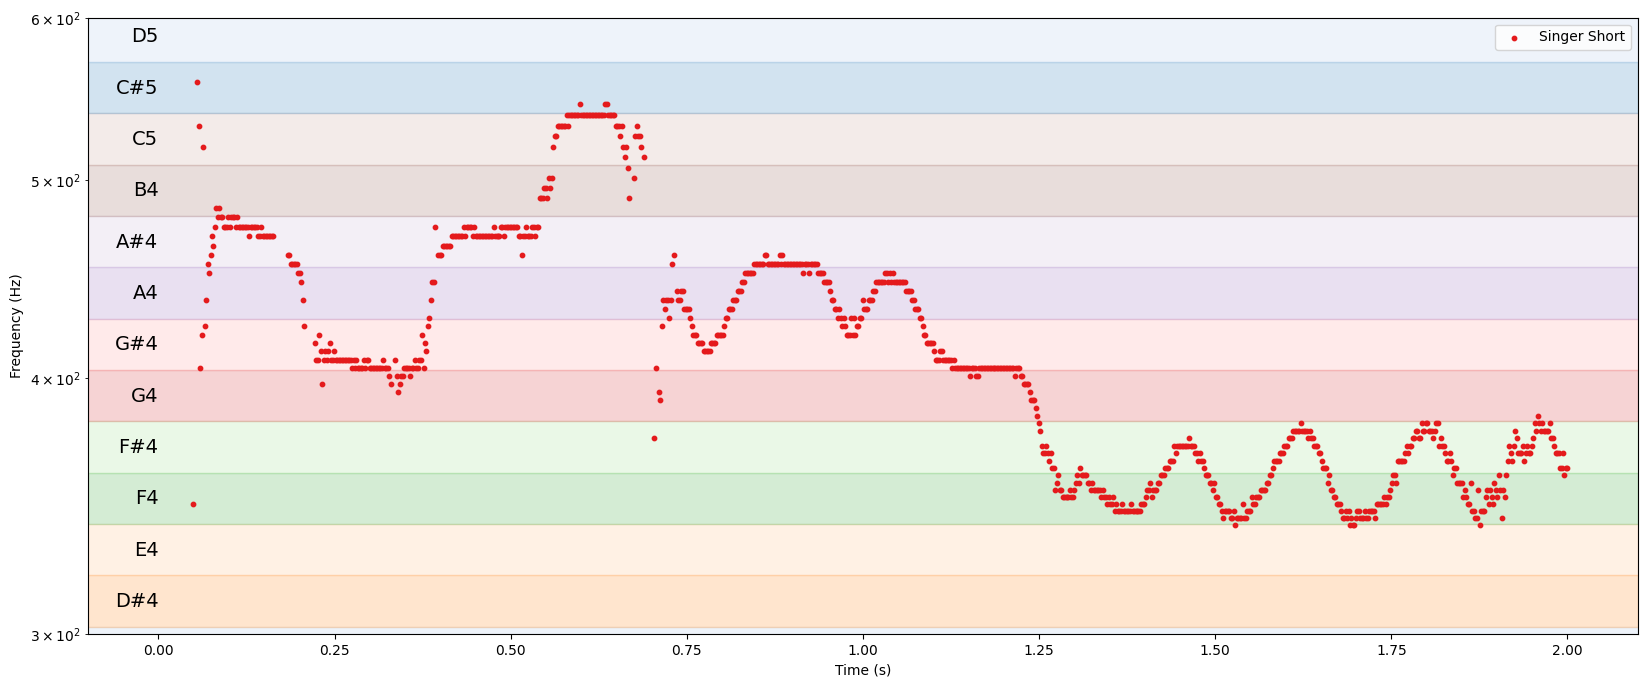

In [11]:
plot_pitches(fmin=300, fmax=600, dataObjects=[singerShortPitches])

# Plotting Data

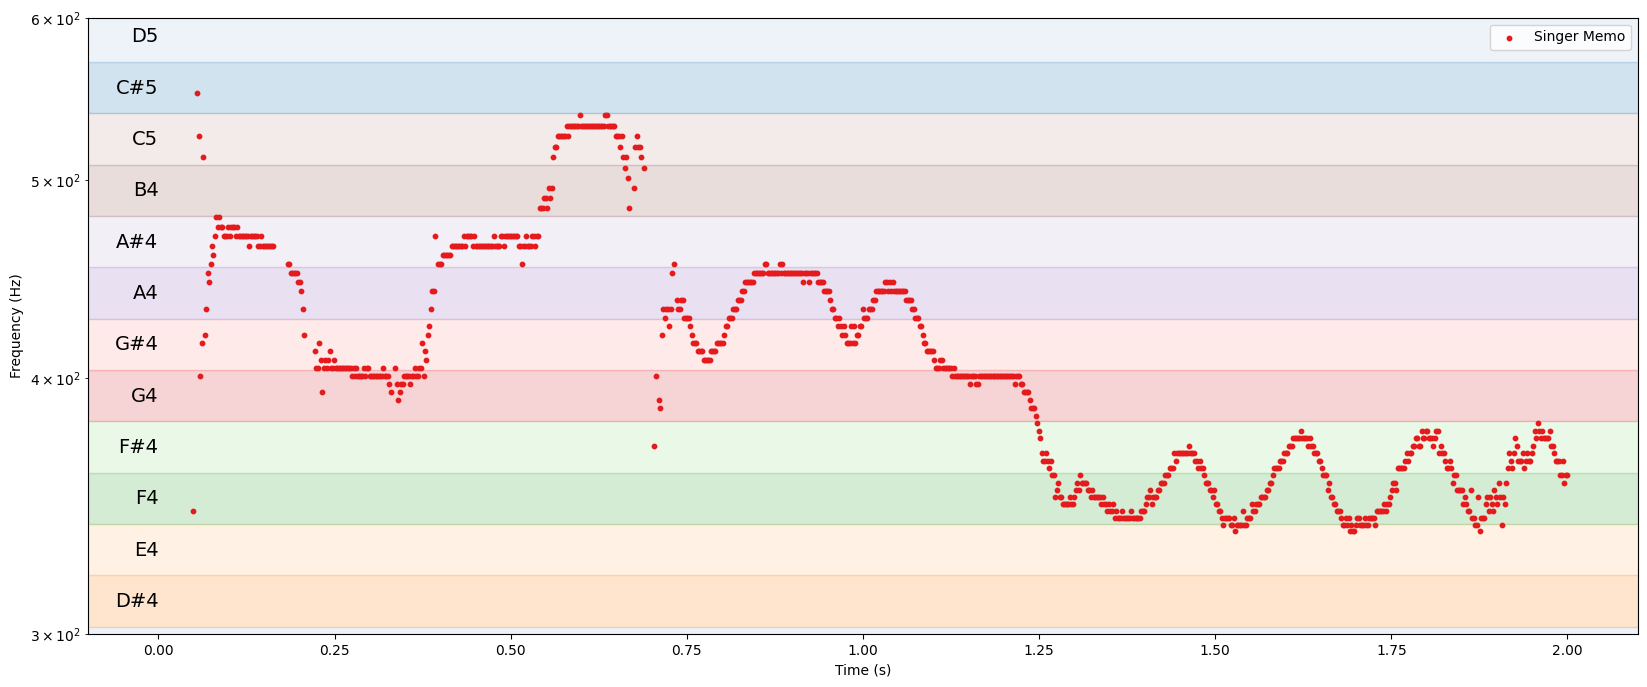

In [32]:
plot_pitches(fmin=300, fmax=600, dataObjects=[singerMemoPitches])

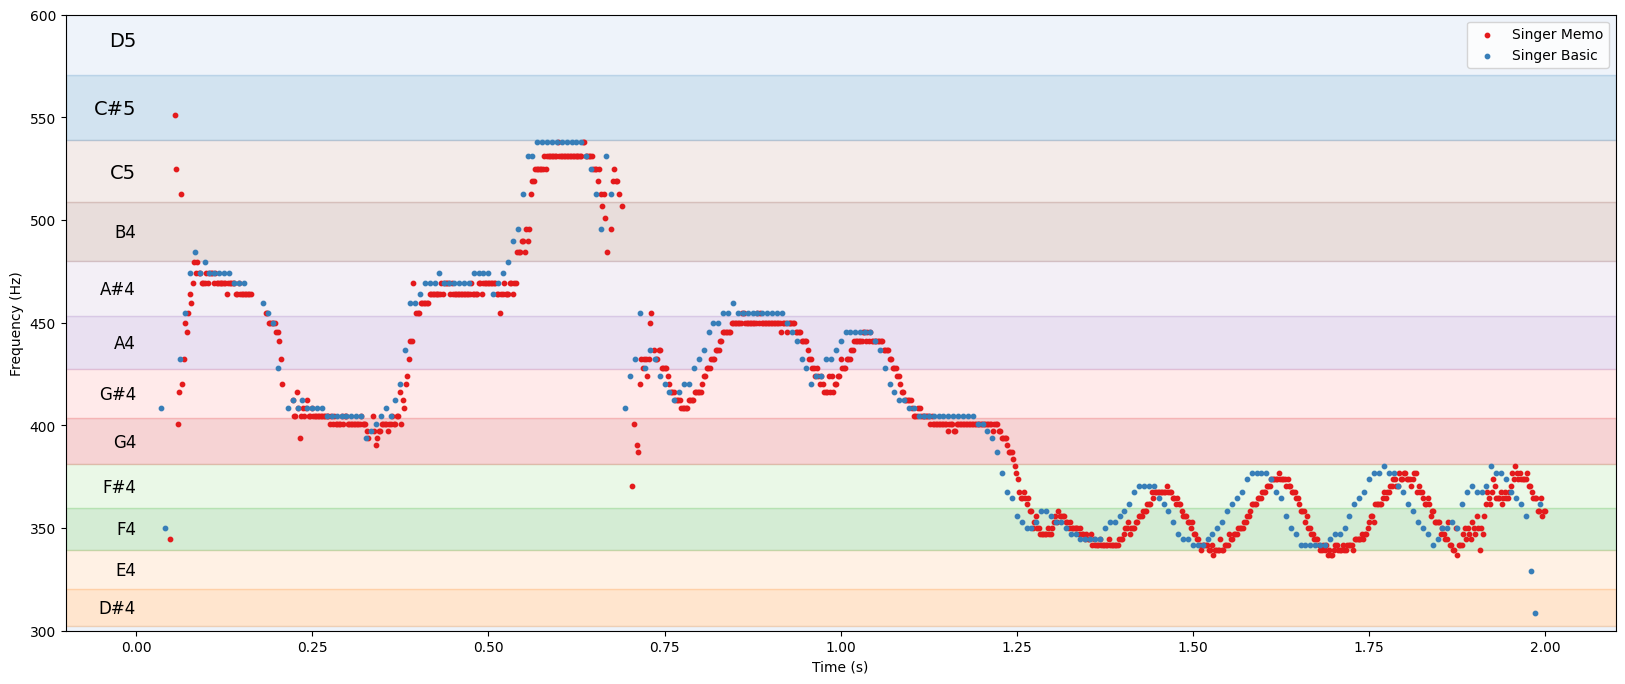

In [60]:
plot_pitches(fmin=300, fmax=600, dataObjects=[singerMemoPitches, singerBasicPitches])

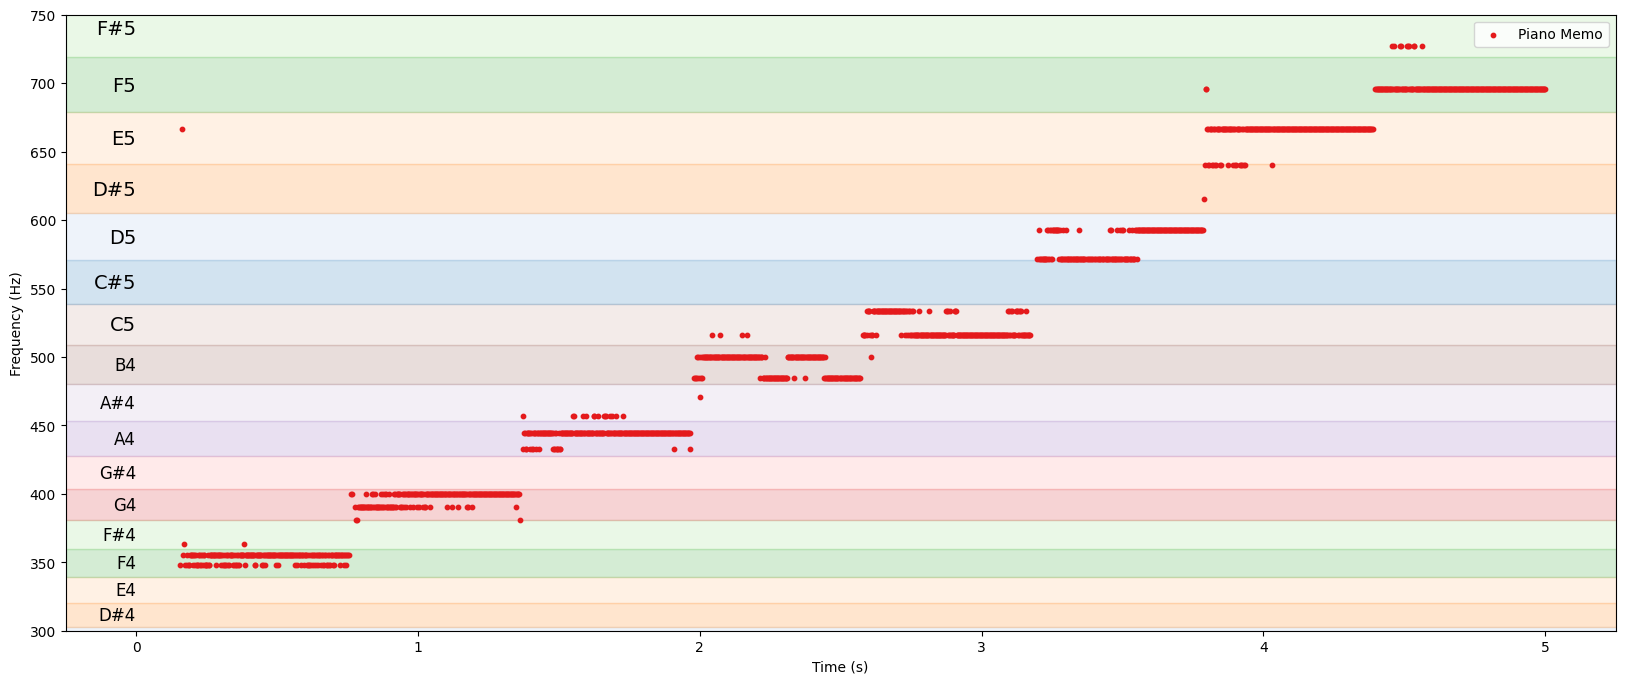

In [61]:
plot_pitches(fmin=300, fmax=750, dataObjects=[pianoMemoPitches])

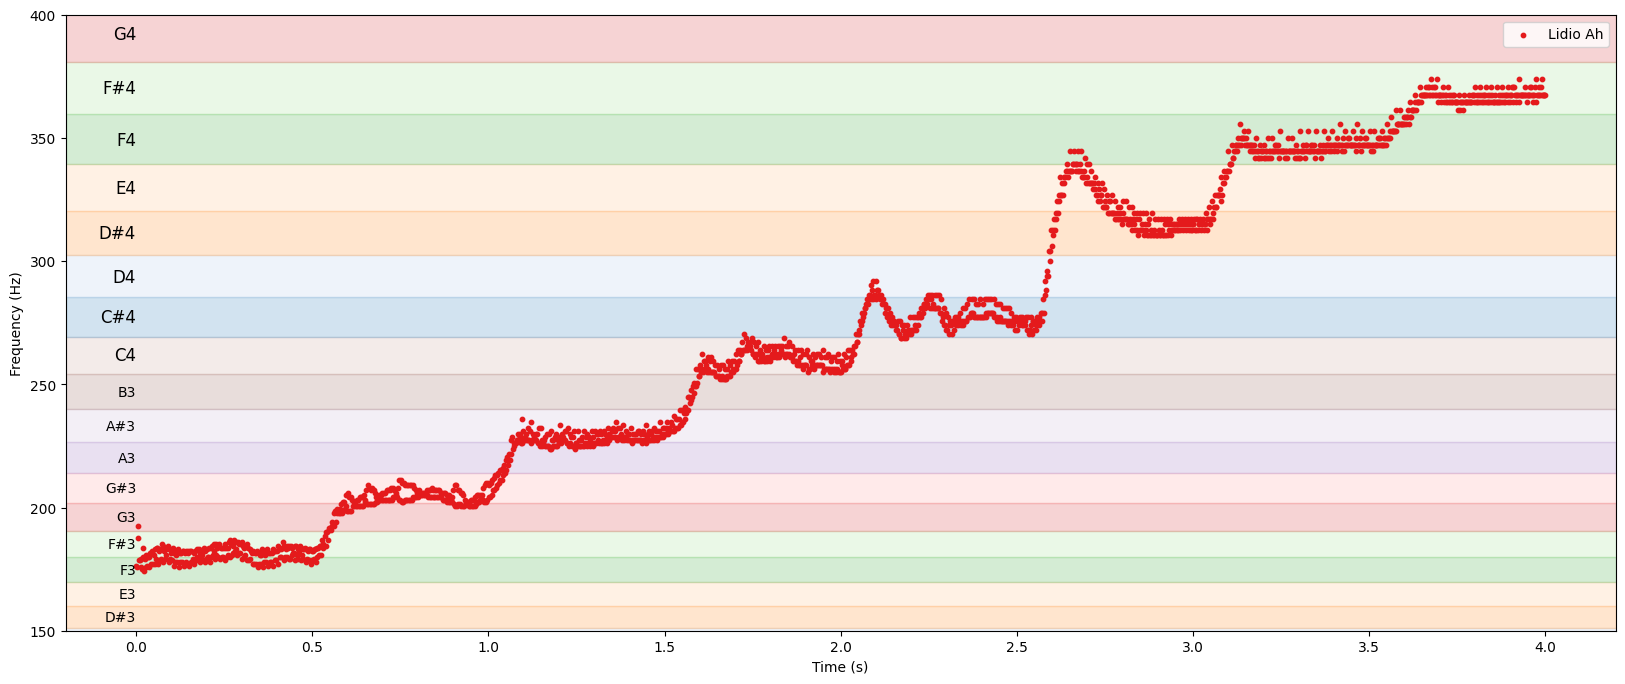

In [91]:
plot_pitches(fmin=150, fmax=400, dataObjects=[lidioAPitches])

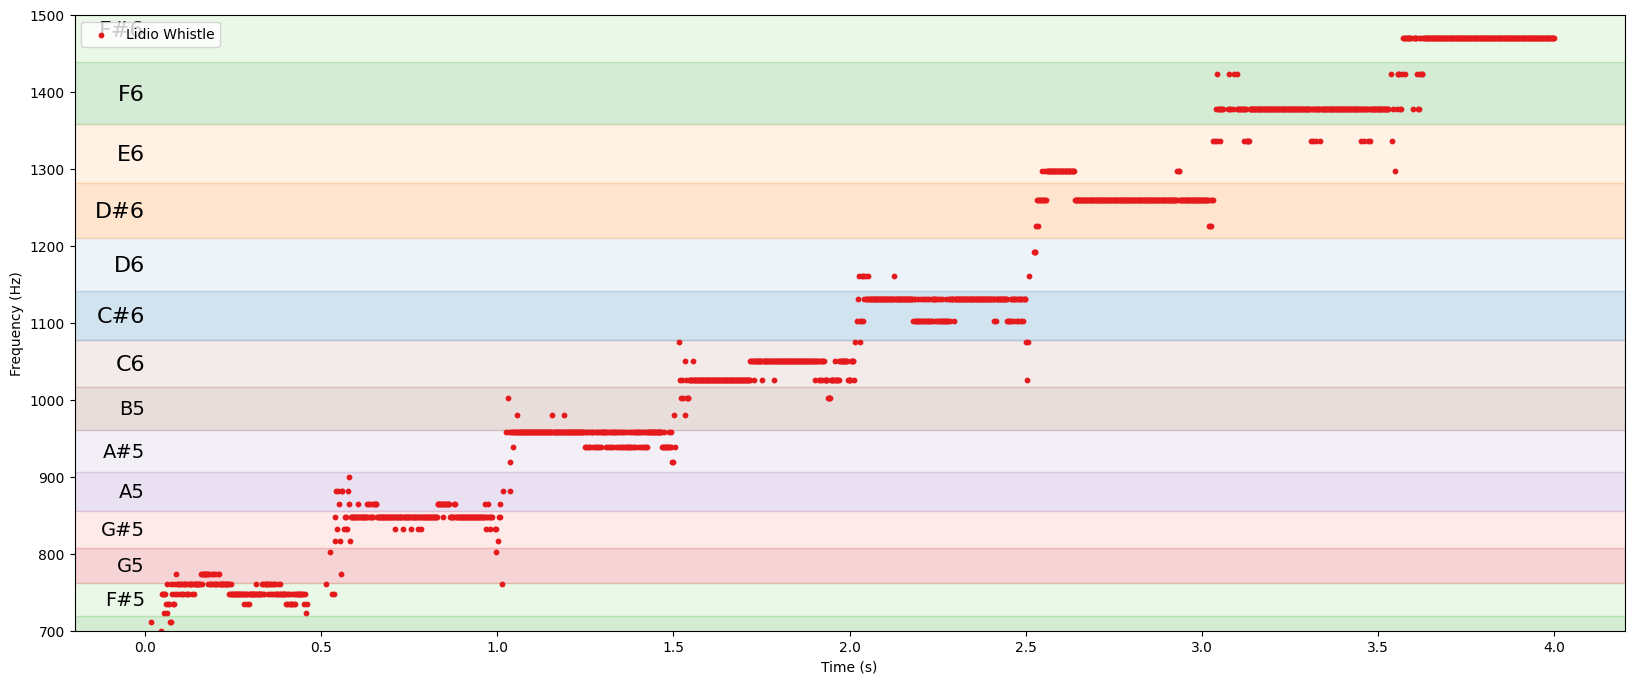

In [94]:
plot_pitches(fmin=700, fmax=1500, dataObjects=[lidioWPitches])

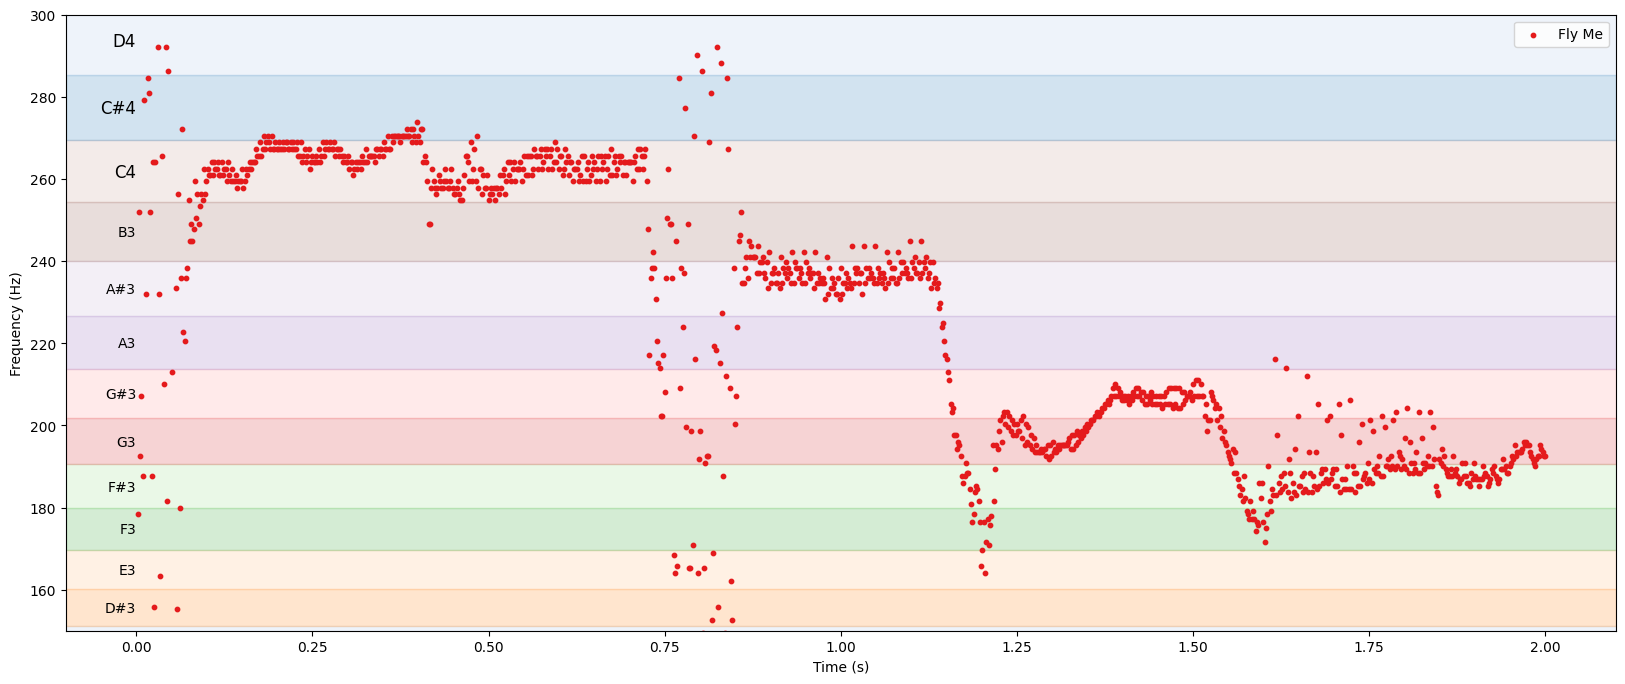

In [77]:
plot_pitches(fmin=150, fmax=300, dataObjects=[flymeMemoPitches])

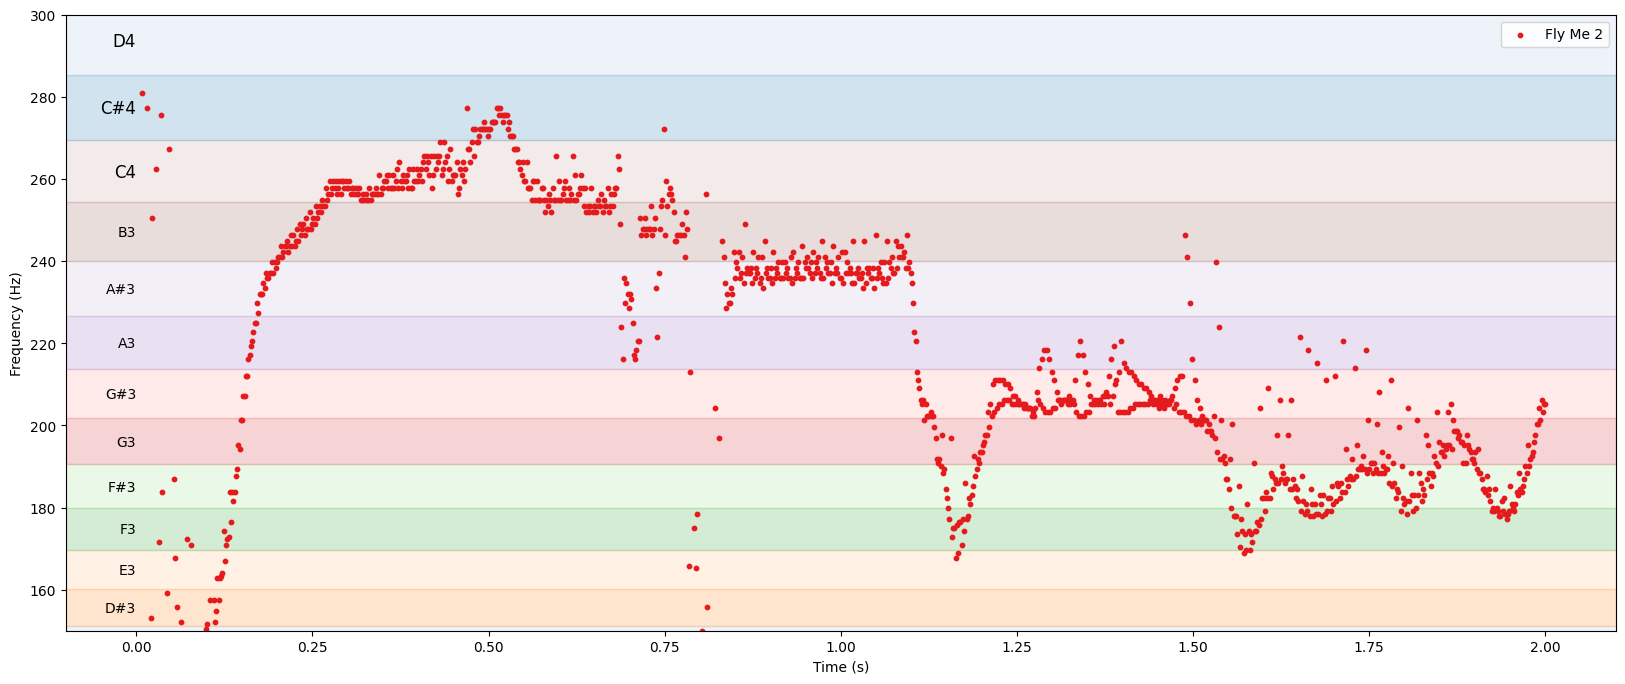

In [82]:
plot_pitches(fmin=150, fmax=300, dataObjects=[flymesPitches])

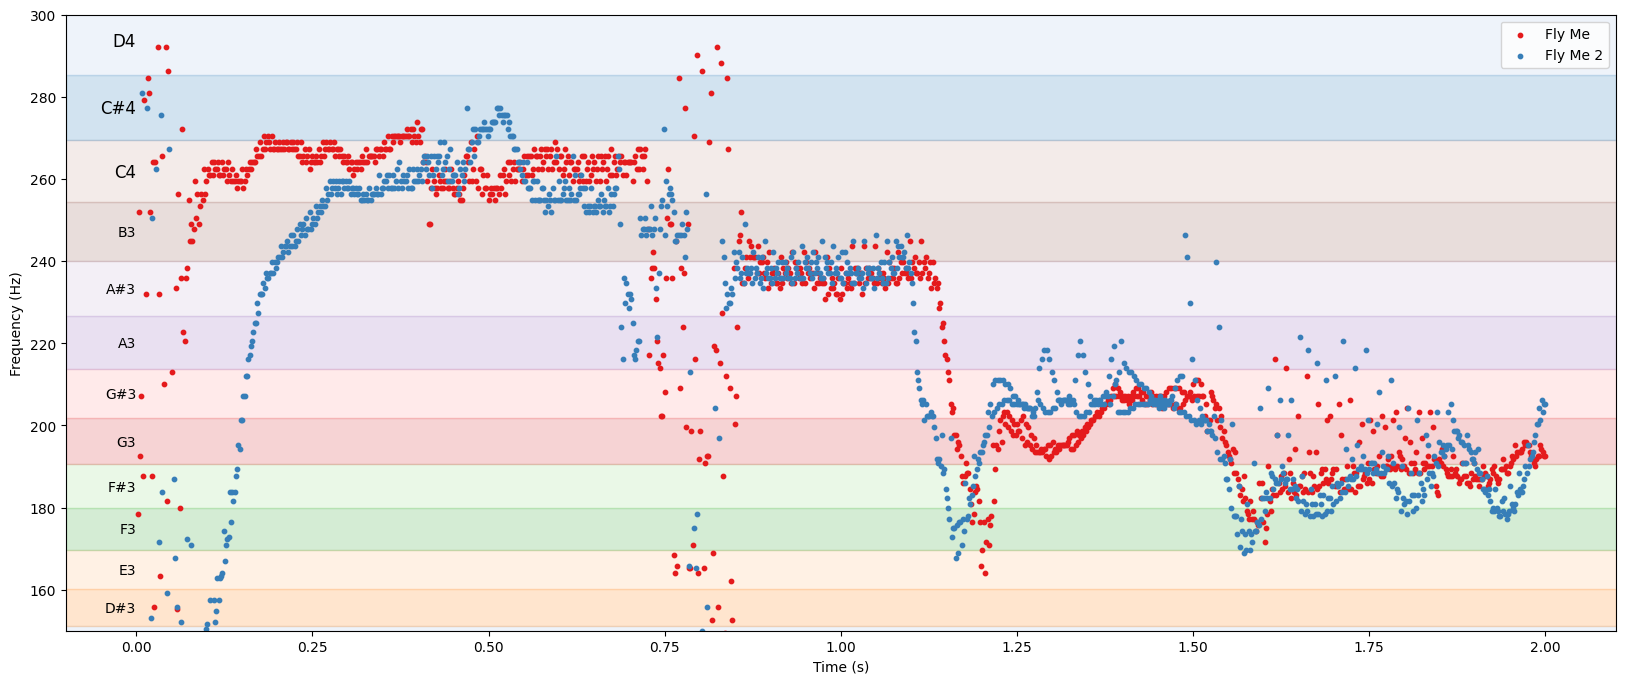

In [83]:
plot_pitches(fmin=150, fmax=300, dataObjects=[flymeMemoPitches, flymesPitches])